In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# import seaborn as sns
import librosa
import librosa.display
import IPython


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm
torch.manual_seed(42)

import seaborn as sns
sns.set()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'
Ravdess_Path='../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/'
Savee_Path='../input/speech-emotion-recognition-en/Savee/'
Tess_Path='../input/speech-emotion-recognition-en/Tess/'

# **CREMA PREPROCESSING**

In [3]:
crema = []
for wav in sorted(os.listdir(Crema_Path)):
    emotion = wav.partition(".wav")[0].split('_')
    if emotion[2] == 'SAD':
        crema.append(('Sad', Crema_Path+'/'+wav))
    elif emotion[2] == 'ANG':
        crema.append(('Anger', Crema_Path+'/'+wav))
    elif emotion[2] == 'DIS':
        crema.append(('Disgust', Crema_Path+'/'+wav))
    elif emotion[2] == 'FEA':
        crema.append(('Fear', Crema_Path+'/'+wav))
    elif emotion[2] == 'HAP':
        crema.append(('Happy', Crema_Path+'/'+wav))
    elif emotion[2] == 'NEU':
        crema.append(('Neutral', Crema_Path+'/'+wav))
    else:
        crema.append(('unknown', Crema_Path+'/'+wav))

df = pd.DataFrame.from_records(crema, columns=['Emotion', 'File_Path'])
df.head()


,Emotion,File_Path
0,Anger,../input/speech-emotion-recognition-en/Crema//...
1,Disgust,../input/speech-emotion-recognition-en/Crema//...
2,Fear,../input/speech-emotion-recognition-en/Crema//...
3,Happy,../input/speech-emotion-recognition-en/Crema//...
4,Neutral,../input/speech-emotion-recognition-en/Crema//...


# **RAVDESS PREPROCESSING**

In [3]:
ravdess_directory_list = os.listdir(Ravdess_Path)

file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess_Path + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        if int(part[2]) != 2:
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess_Path + i + '/' + f)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])
path_df = pd.DataFrame(file_path, columns=['File_Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.Emotion.replace({1:'Neutral', 3:'Happy', 4:'Sad', 5:'Anger', 6:'Fear', 7:'Disgust', 8:'Surprise'},
                            inplace=True)
print(df.head())

    Emotion                                          File_Path
0  Surprise  ../input/speech-emotion-recognition-en/Ravdess...
1   Neutral  ../input/speech-emotion-recognition-en/Ravdess...
2   Disgust  ../input/speech-emotion-recognition-en/Ravdess...
3   Disgust  ../input/speech-emotion-recognition-en/Ravdess...
4   Neutral  ../input/speech-emotion-recognition-en/Ravdess...


# **SAVEE PREPROCESSING**

In [ ]:
savee_directory_list = os.listdir(Savee_Path)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('Anger')
    elif ele=='d':
        file_emotion.append('Disgust')
    elif ele=='f':
        file_emotion.append('Fear')
    elif ele=='h':
        file_emotion.append('Happy')
    elif ele=='n':
        file_emotion.append('Neutral')
    elif ele=='sa':
        file_emotion.append('Sad')
    else:
        file_emotion.append('Surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['File_Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.head()

# **TESS PREPROCESSING**

In [7]:
tess_directory_list = os.listdir(Tess_Path)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess_Path + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('Surprise')
        elif part == 'fear':
            file_emotion.append('Fear')
        elif part == 'sad':
            file_emotion.append('Sad')
        elif part == 'angry':
            file_emotion.append('Anger')
        elif part == 'disgust':
            file_emotion.append('Disgust')
        elif part == 'happy':
            file_emotion.append('Happy')
        elif part == 'neutral':
            file_emotion.append('Neutral')
        file_path.append(Tess_Path + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['File_Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.head()

,Emotion,File_Path
0,Fear,../input/speech-emotion-recognition-en/Tess/YA...
1,Fear,../input/speech-emotion-recognition-en/Tess/YA...
2,Fear,../input/speech-emotion-recognition-en/Tess/YA...
3,Fear,../input/speech-emotion-recognition-en/Tess/YA...
4,Fear,../input/speech-emotion-recognition-en/Tess/YA...


In [4]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder 
encoder = LabelEncoder()
# Fit the encoder on the column and transform the values
df['Emotion_encoded'] = encoder.fit_transform(df['Emotion'])

# Get the mapping between original labels and encoded values
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))


In [5]:
label_mapping

{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5}

In [6]:
df['Emotion'].unique()

array(['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
      dtype=object)

In [7]:
emotion_names=df['Emotion'].unique()

In [8]:
!pip install torchaudio

In [9]:
import torchaudio
import torchaudio.transforms as transforms

S_dB_Total = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(df.File_Path)):
    waveform, sample_rate = torchaudio.load(path)
    
    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)

    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)
    
    S = mel_transform(waveform)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)

    S_dB_Total.append(S_dB.squeeze())

0it [00:00, ?it/s]/tmp/ipykernel_35/2468677012.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torch.tensor(waveform).to(device)
7442it [01:33, 79.26it/s]


In [10]:
sizes=[]
for x in S_dB_Total:
    sizes.append(x.shape[1])

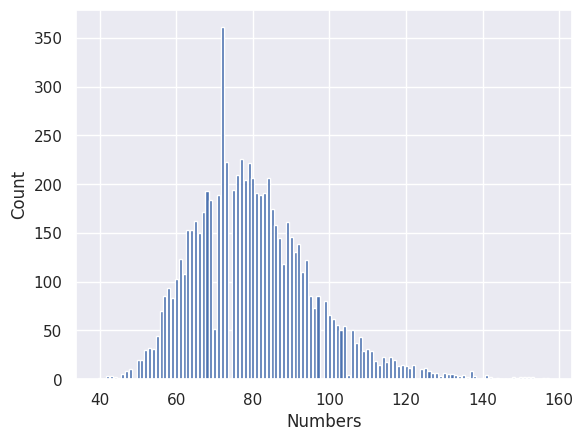

min is 40
max is 157


In [11]:
# Calculate the bin counts
bincount_array = np.histogram(sizes, bins=np.arange(min(sizes), max(sizes)+2))[0]

# Create a list of labels for the x-axis
x_labels = np.arange(min(sizes), max(sizes)+1)

# Plot the bin counts as a bar plot
plt.bar(x_labels, bincount_array)

# Set labels and title
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.show()

print(f'min is {min(sizes)}')
print(f'max is {max(sizes)}')


In [12]:
padding_length = 160
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
data_2D = np.array(padded_list)
    

In [13]:
data_2D.shape

(7442, 128, 160)

In [14]:
#normalization
from sklearn.preprocessing import MinMaxScaler

# Reshape the array to 2D
reshaped_data = data_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(data_2D.shape)


In [15]:
normalized_data[1]

array([[0.56973195, 0.5444743 , 0.51813316, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.5450095 , 0.5570548 , 0.541499  , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.512481  , 0.55639714, 0.592978  , ..., 0.64415836, 0.64415836,
        0.64415836],
       ...,
       [0.4755556 , 0.472118  , 0.4689895 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.4661117 , 0.45966327, 0.44934118, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.448575  , 0.45664725, 0.44868642, ..., 0.64415836, 0.64415836,
        0.64415836]], dtype=float32)

In [16]:
data=np.expand_dims(normalized_data, axis=1)

In [17]:
labels=df.Emotion_encoded.to_numpy()

In [18]:
labels.shape

(7442,)

In [19]:
data.shape

(7442, 1, 128, 160)

In [20]:
#train test split
from sklearn.model_selection import train_test_split
# Perform the train-test split (70% train & validation, 30% test )
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Perform the train-validation split (5% test, 95% train)
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size=0.1, stratify=y_trainAndVal, random_state=42)

# Print the sizes of each split
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Train set size: 5357
Validation set size: 596
Test set size: 1489


In [21]:
X_train.shape

(5357, 1, 128, 160)

In [22]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self,audio,label):
        self.audios=audio
        self.labels=label

    def __len__(self):
        return len(self.audios)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.audios[idx]
    
    def get_batch_labels(self, idx):
    # Fetch a batch of inputs
        return self.labels[idx]

    
    def __getitem__(self, index):
        audios=self.get_batch_imgs(index)
        labels=self.get_batch_labels(index)
        return audios,labels


In [23]:
train_dataset = AudioDataset(X_train,y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Create a DataLoader from the dataset

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=8, shuffle=False)


# Architecture

In [24]:
#change nn.sequential to take dict to make more readable 

class ParaNet(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        self.dropout=nn.Dropout(p=0.3)
        self.relu=nn.ReLU()
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,128,160) --> (16,128,80) -> (32,32,20) -> (64,8,5)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),  #(1,128,160) - > (16,128,160)
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size  #(16,128,160) - > (16,64,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(16,64,80) - > (32,64,80)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters #(32,64,80) - > (32,16,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(32,16,20) - > (64,16,20)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(64,16,20) - > (64,4,5)
            nn.Dropout(p=0.4),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,265,160) --> (32,128,80) -> (64,32,20) -> (128,8,5)
        self.conv2Dblock2 = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=32, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),#(1,256,160) - > (32,256,160)
            nn.BatchNorm2d(32), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size (32,265,160) - > (32,128,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=32, 
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=5,
                stride=1,
                padding=2
                      ),#(32,128,55) - > (64,128,55)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters (64,128,55) - > (64,32,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=64,
                out_channels=128, # expand output feature map volume's depth to 64
                kernel_size=7,
                stride=1,
                padding=3
                      ),#(64,32,20) - > (128,32,13)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(128,32,13) - > (128,8,5)
            nn.Dropout(p=0.4),
        )
        
        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 6 logits 
        
        # 64*8*5+128*8*5 == 7680 input features --> 6 output emotions 
        self.fc1_linear = nn.Linear(64*4*5 + 128*4*5,num_emotions) 
        
        ### Softmax layer for the 6 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 

        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 

        
        
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2], dim=1)
        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        output_softmax = self.softmax_out(output_logits)

        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       


In [25]:
#change nn.sequential to take dict to make more readable 

class ParaNetTransformer(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 256-->512--->256 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=128, # input feature (frequency) dim after maxpooling 128*110 -> 128*27 (Melspectorgram*time)
            nhead=32, # 32 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=1024, # 2 linear layers in each encoder block's feedforward network: dim 128-->512--->128
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=6)

        
        
        self.dropout=nn.Dropout(p=0.3)
        self.relu=nn.ReLU()
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,128,160) --> (16,128,80) -> (32,32,20) -> (64,8,5)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),  #(1,128,160) - > (16,128,160)
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size  #(16,128,160) - > (16,64,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(16,64,80) - > (32,64,80)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters #(32,64,80) - > (32,16,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(32,16,20) - > (64,16,20)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(64,16,20) - > (64,4,5)
            nn.Dropout(p=0.4),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,265,160) --> (32,128,80) -> (64,32,20) -> (128,8,5)
        self.conv2Dblock2 = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=32, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),#(1,256,160) - > (32,256,160)
            nn.BatchNorm2d(32), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size (32,265,160) - > (32,128,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=32, 
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=5,
                stride=1,
                padding=2
                      ),#(32,128,55) - > (64,128,55)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters (64,128,55) - > (64,32,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=64,
                out_channels=128, # expand output feature map volume's depth to 64
                kernel_size=7,
                stride=1,
                padding=3
                      ),#(64,32,20) - > (128,32,13)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(128,32,13) - > (128,8,5)
            nn.Dropout(p=0.4),
        )
        
        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 6 logits 
        
        # 64*8*5+128*8*5 == 7680 input features --> 6 output emotions 
        self.fc1_linear = nn.Linear(64*4*5 + 128*4*5 +128,num_emotions) 
        
        ### Softmax layer for the 6 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 

        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 

        
        x_maxpool = self.transformer_maxpool(x)
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        x = x_maxpool_reduced.permute(2,0,1) 
        transformer_output = self.transformer_encoder(x)
        transformer_embedding = torch.mean(transformer_output, dim=0)
        
        
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)
        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        output_softmax = self.softmax_out(output_logits)

        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       


In [27]:
from torchinfo import summary
# need device to instantiate model
device = 'cuda'

# instantiate model for 8 emotions and move to GPU 
model = ParaNet(6).to(device)

# include input feature map dims in call to summary()
summary(model, input_size=(32, 1, 128, 160))


Layer (type:depth-idx)                   Output Shape              Param #
ParaNet                                  [32, 6]                   --
├─Sequential: 1-1                        [32, 64, 4, 5]            --
│    └─Conv2d: 2-1                       [32, 16, 128, 160]        160
│    └─BatchNorm2d: 2-2                  [32, 16, 128, 160]        32
│    └─ReLU: 2-3                         [32, 16, 128, 160]        --
│    └─MaxPool2d: 2-4                    [32, 16, 64, 80]          --
│    └─Dropout: 2-5                      [32, 16, 64, 80]          --
│    └─Conv2d: 2-6                       [32, 32, 64, 80]          4,640
│    └─BatchNorm2d: 2-7                  [32, 32, 64, 80]          64
│    └─ReLU: 2-8                         [32, 32, 64, 80]          --
│    └─MaxPool2d: 2-9                    [32, 32, 16, 20]          --
│    └─Dropout: 2-10                     [32, 32, 16, 20]          --
│    └─Conv2d: 2-11                      [32, 64, 16, 20]          18,496
│    └─

In [28]:
from torchinfo import summary
# need device to instantiate model
device = 'cuda'

# instantiate model for 8 emotions and move to GPU 
model = ParaNetTransformer(6).to(device)

# include input feature map dims in call to summary()
summary(model, input_size=(32, 1, 128, 160))


Layer (type:depth-idx)                        Output Shape              Param #
ParaNetTransformer                            [32, 6]                   --
├─Sequential: 1-1                             [32, 64, 4, 5]            --
│    └─Conv2d: 2-1                            [32, 16, 128, 160]        160
│    └─BatchNorm2d: 2-2                       [32, 16, 128, 160]        32
│    └─ReLU: 2-3                              [32, 16, 128, 160]        --
│    └─MaxPool2d: 2-4                         [32, 16, 64, 80]          --
│    └─Dropout: 2-5                           [32, 16, 64, 80]          --
│    └─Conv2d: 2-6                            [32, 32, 64, 80]          4,640
│    └─BatchNorm2d: 2-7                       [32, 32, 64, 80]          64
│    └─ReLU: 2-8                              [32, 32, 64, 80]          --
│    └─MaxPool2d: 2-9                         [32, 32, 16, 20]          --
│    └─Dropout: 2-10                          [32, 32, 16, 20]          --
│    └─Conv2d: 2

In [29]:
import torch.optim as optim

EPOCHS=500
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn =nn.CrossEntropyLoss().to(DEVICE)

LEARNING_RATE=1e-4
model = ParaNet(6).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=LEARNING_RATE, momentum=0.8)

In [30]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    for train_input, train_label in tqdm(data_loader):
        train_label = train_label.to(device)
        train_input = train_input.to(device)

        optimizer.zero_grad()
        
        output_logits, output_softmax = model(train_input.float())
        predictions = torch.argmax(output_softmax,dim=1)
        total_predictions += train_label.size(0)
        
        correct_predictions += (predictions == train_label).sum().item()
        
        loss = loss_fn(output_logits, train_label)

        losses.append(loss.item())


        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']}")

    accuracy = correct_predictions / total_predictions
    mean_loss = np.mean(losses)

    return mean_loss, accuracy


In [31]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():            
        for val_input, val_label in data_loader:
            val_label = val_label.to(device)
            val_input = val_input.to(device)

            optimizer.zero_grad()

            output_logits, output_softmax = model(val_input.float())

            predictions = torch.argmax(output_softmax,dim=1)
            total_predictions += val_label.size(0)

            correct_predictions += (predictions == val_label).sum().item()

            loss = loss_fn(output_logits, val_label)

            losses.append(loss.item())
            
            



        accuracy = correct_predictions / total_predictions
        mean_loss = np.mean(losses)
        

    return mean_loss, accuracy

In [32]:
from collections import defaultdict
import math
history = defaultdict(list)
loss=math.inf
epochs_without_improvement = 0
patience = 10  # Number of epochs to wait for improvement


In [33]:
for epoch in range(EPOCHS):


    train_loss,train_acc = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)
    
    val_loss,val_acc = eval_model(model,val_dataloader,loss_fn, DEVICE)
    
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print(f'Train loss {train_loss}')
    print(f'Train Accuracy {train_acc}')

    print(f'Val   loss {val_loss}')
    print(f'Val   Acc {val_acc}')

    print()
        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement == patience:
        print("Early stopping triggered. No improvement in", patience, "epochs.")
        break



    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    
    history['train_Accuracy'].append(train_acc)
    history['val_Accuracy'].append(val_acc)

    #save this incase of failure
    torch.save(model.state_dict(), 'current_model_state.bin')
    
    
#save last state to train later
torch.save(model.state_dict(), 'last_model_state.bin')


100%|██████████| 670/670 [00:07<00:00, 85.52it/s]


Epoch 1, Learning Rate: 0.0001
Epoch 1/500
----------
Train loss 1.7381932600220638
Train Accuracy 0.31864849729326117
Val   loss 1.4246209478378296
Val   Acc 0.42449664429530204



100%|██████████| 670/670 [00:07<00:00, 92.98it/s]


Epoch 2, Learning Rate: 0.0001
Epoch 2/500
----------
Train loss 1.5677809286473403
Train Accuracy 0.38323688631696845
Val   loss 1.391950072447459
Val   Acc 0.43288590604026844



100%|██████████| 670/670 [00:07<00:00, 93.41it/s]


Epoch 3, Learning Rate: 0.0001
Epoch 3/500
----------
Train loss 1.50455655855919
Train Accuracy 0.3953705432144857
Val   loss 1.3665372021993
Val   Acc 0.43456375838926176



100%|██████████| 670/670 [00:07<00:00, 93.46it/s]


Epoch 4, Learning Rate: 0.0001
Epoch 4/500
----------
Train loss 1.4652167434123025
Train Accuracy 0.40787754340115734
Val   loss 1.3706703130404154
Val   Acc 0.4597315436241611



100%|██████████| 670/670 [00:07<00:00, 93.10it/s]


Epoch 5, Learning Rate: 0.0001
Epoch 5/500
----------
Train loss 1.420917595144528
Train Accuracy 0.4321448571961919
Val   loss 1.366887893676758
Val   Acc 0.4261744966442953



100%|██████████| 670/670 [00:07<00:00, 91.18it/s]


Epoch 6, Learning Rate: 0.0001
Epoch 6/500
----------
Train loss 1.3819394922968167
Train Accuracy 0.4416651110696285
Val   loss 1.2983422231674195
Val   Acc 0.5016778523489933



100%|██████████| 670/670 [00:07<00:00, 91.33it/s]


Epoch 7, Learning Rate: 0.0001
Epoch 7/500
----------
Train loss 1.356118307629628
Train Accuracy 0.46611909650924027
Val   loss 1.3256119839350382
Val   Acc 0.4446308724832215



100%|██████████| 670/670 [00:07<00:00, 91.64it/s]


Epoch 8, Learning Rate: 0.0001
Epoch 8/500
----------
Train loss 1.3231900727570947
Train Accuracy 0.46929251446705245
Val   loss 1.2549413744608562
Val   Acc 0.5100671140939598



100%|██████████| 670/670 [00:07<00:00, 91.28it/s]


Epoch 9, Learning Rate: 0.0001
Epoch 9/500
----------
Train loss 1.3082459115270357
Train Accuracy 0.47750606682844876
Val   loss 1.2169230898221335
Val   Acc 0.5385906040268457



100%|██████████| 670/670 [00:07<00:00, 90.81it/s]


Epoch 10, Learning Rate: 0.0001
Epoch 10/500
----------
Train loss 1.2669725400298388
Train Accuracy 0.49131976852716075
Val   loss 1.218866138458252
Val   Acc 0.5486577181208053



100%|██████████| 670/670 [00:07<00:00, 90.37it/s]


Epoch 11, Learning Rate: 0.0001
Epoch 11/500
----------
Train loss 1.261316872532688
Train Accuracy 0.5008400224005973
Val   loss 1.2427755777041118
Val   Acc 0.5033557046979866



100%|██████████| 670/670 [00:07<00:00, 90.58it/s]


Epoch 12, Learning Rate: 0.0001
Epoch 12/500
----------
Train loss 1.2413855430795186
Train Accuracy 0.5030800821355236
Val   loss 1.1985329778989156
Val   Acc 0.5201342281879194



100%|██████████| 670/670 [00:07<00:00, 90.64it/s]


Epoch 13, Learning Rate: 0.0001
Epoch 13/500
----------
Train loss 1.2160985943986409
Train Accuracy 0.5191338435691618
Val   loss 1.1425935792922974
Val   Acc 0.5553691275167785



100%|██████████| 670/670 [00:07<00:00, 90.91it/s]


Epoch 14, Learning Rate: 0.0001
Epoch 14/500
----------
Train loss 1.205898850800386
Train Accuracy 0.5269740526414037
Val   loss 1.1488745069503785
Val   Acc 0.5704697986577181



100%|██████████| 670/670 [00:07<00:00, 90.84it/s]


Epoch 15, Learning Rate: 0.0001
Epoch 15/500
----------
Train loss 1.1906347731600946
Train Accuracy 0.5264140377076723
Val   loss 1.1629650648434957
Val   Acc 0.5637583892617449



100%|██████████| 670/670 [00:07<00:00, 90.02it/s]


Epoch 16, Learning Rate: 0.0001
Epoch 16/500
----------
Train loss 1.1637221441784902
Train Accuracy 0.5473212619003174
Val   loss 1.2464097054799397
Val   Acc 0.5016778523489933



100%|██████████| 670/670 [00:07<00:00, 92.15it/s]


Epoch 17, Learning Rate: 0.0001
Epoch 17/500
----------
Train loss 1.1482689359739646
Train Accuracy 0.5512413664364383
Val   loss 1.126582417488098
Val   Acc 0.5721476510067114



100%|██████████| 670/670 [00:07<00:00, 93.67it/s]


Epoch 18, Learning Rate: 0.0001
Epoch 18/500
----------
Train loss 1.1445339399487224
Train Accuracy 0.5445211872316595
Val   loss 1.1650622995694477
Val   Acc 0.5721476510067114



100%|██████████| 670/670 [00:07<00:00, 92.94it/s]


Epoch 19, Learning Rate: 0.0001
Epoch 19/500
----------
Train loss 1.1277323926117884
Train Accuracy 0.5557214859062908
Val   loss 1.125543696085612
Val   Acc 0.5721476510067114



100%|██████████| 670/670 [00:07<00:00, 92.76it/s]


Epoch 20, Learning Rate: 0.0001
Epoch 20/500
----------
Train loss 1.127190270619606
Train Accuracy 0.5620683218219152
Val   loss 1.0921749265988667
Val   Acc 0.6124161073825504



100%|██████████| 670/670 [00:07<00:00, 92.07it/s]


Epoch 21, Learning Rate: 0.0001
Epoch 21/500
----------
Train loss 1.1121136490311196
Train Accuracy 0.5562815008400224
Val   loss 1.085520044565201
Val   Acc 0.5939597315436241



100%|██████████| 670/670 [00:07<00:00, 92.26it/s]


Epoch 22, Learning Rate: 0.0001
Epoch 22/500
----------
Train loss 1.099079507945189
Train Accuracy 0.5740153070748554
Val   loss 1.0782028492291769
Val   Acc 0.5838926174496645



100%|██████████| 670/670 [00:07<00:00, 92.83it/s]


Epoch 23, Learning Rate: 0.0001
Epoch 23/500
----------
Train loss 1.0801659605841138
Train Accuracy 0.5777487399663991
Val   loss 1.0904476952552795
Val   Acc 0.5906040268456376



100%|██████████| 670/670 [00:07<00:00, 91.98it/s]


Epoch 24, Learning Rate: 0.0001
Epoch 24/500
----------
Train loss 1.071679585104558
Train Accuracy 0.5801754713459025
Val   loss 1.08935817917188
Val   Acc 0.5906040268456376



100%|██████████| 670/670 [00:07<00:00, 91.89it/s]


Epoch 25, Learning Rate: 0.0001
Epoch 25/500
----------
Train loss 1.0646758106662266
Train Accuracy 0.5891357102856076
Val   loss 1.1165090950330099
Val   Acc 0.587248322147651



100%|██████████| 670/670 [00:07<00:00, 92.34it/s]


Epoch 26, Learning Rate: 0.0001
Epoch 26/500
----------
Train loss 1.0589499375713405
Train Accuracy 0.586522307261527
Val   loss 1.0776169220606486
Val   Acc 0.5939597315436241



100%|██████████| 670/670 [00:07<00:00, 92.34it/s]


Epoch 27, Learning Rate: 0.0001
Epoch 27/500
----------
Train loss 1.04600821826885
Train Accuracy 0.5932424864663057
Val   loss 1.0807557113965351
Val   Acc 0.5989932885906041



100%|██████████| 670/670 [00:07<00:00, 92.65it/s]


Epoch 28, Learning Rate: 0.0001
Epoch 28/500
----------
Train loss 1.0380733141258582
Train Accuracy 0.599402650737353
Val   loss 1.071343764066696
Val   Acc 0.6090604026845637



100%|██████████| 670/670 [00:07<00:00, 92.63it/s]


Epoch 29, Learning Rate: 0.0001
Epoch 29/500
----------
Train loss 1.034828310982505
Train Accuracy 0.6012693671831248
Val   loss 1.0370326809088388
Val   Acc 0.6140939597315436



100%|██████████| 670/670 [00:07<00:00, 92.51it/s]


Epoch 30, Learning Rate: 0.0001
Epoch 30/500
----------
Train loss 1.01324437064911
Train Accuracy 0.6104162777674071
Val   loss 1.114592647155126
Val   Acc 0.5637583892617449



100%|██████████| 670/670 [00:07<00:00, 92.21it/s]


Epoch 31, Learning Rate: 0.0001
Epoch 31/500
----------
Train loss 1.0014760266489058
Train Accuracy 0.6128430091469106
Val   loss 1.1096138842900594
Val   Acc 0.5570469798657718



100%|██████████| 670/670 [00:07<00:00, 92.63it/s]


Epoch 32, Learning Rate: 0.0001
Epoch 32/500
----------
Train loss 0.9991127808147402
Train Accuracy 0.6100429344782528
Val   loss 1.113049059311549
Val   Acc 0.5486577181208053



100%|██████████| 670/670 [00:07<00:00, 91.33it/s]


Epoch 33, Learning Rate: 0.0001
Epoch 33/500
----------
Train loss 0.9941482267717817
Train Accuracy 0.6128430091469106
Val   loss 1.0481885719299315
Val   Acc 0.5922818791946308



100%|██████████| 670/670 [00:07<00:00, 90.84it/s]


Epoch 34, Learning Rate: 0.0001
Epoch 34/500
----------
Train loss 0.9838380141934352
Train Accuracy 0.6232966212432332
Val   loss 1.0093147583802542
Val   Acc 0.6140939597315436



100%|██████████| 670/670 [00:07<00:00, 91.83it/s]


Epoch 35, Learning Rate: 0.0001
Epoch 35/500
----------
Train loss 0.9581468734278608
Train Accuracy 0.6363636363636364
Val   loss 1.0573987762133281
Val   Acc 0.6023489932885906



100%|██████████| 670/670 [00:07<00:00, 92.23it/s]


Epoch 36, Learning Rate: 0.0001
Epoch 36/500
----------
Train loss 0.9564799193793269
Train Accuracy 0.6371103229419451
Val   loss 1.0511852165063222
Val   Acc 0.610738255033557



100%|██████████| 670/670 [00:07<00:00, 92.40it/s]


Epoch 37, Learning Rate: 0.0001
Epoch 37/500
----------
Train loss 0.9559466477205504
Train Accuracy 0.6376703378756767
Val   loss 1.0250286237398782
Val   Acc 0.6140939597315436



100%|██████████| 670/670 [00:07<00:00, 92.79it/s]


Epoch 38, Learning Rate: 0.0001
Epoch 38/500
----------
Train loss 0.9486825382086768
Train Accuracy 0.6339369049841329
Val   loss 1.0502015729745229
Val   Acc 0.6090604026845637



100%|██████████| 670/670 [00:07<00:00, 93.73it/s]


Epoch 39, Learning Rate: 0.0001
Epoch 39/500
----------
Train loss 0.929554548681672
Train Accuracy 0.641963785700952
Val   loss 1.0772767996788024
Val   Acc 0.587248322147651



100%|██████████| 670/670 [00:07<00:00, 93.47it/s]


Epoch 40, Learning Rate: 0.0001
Epoch 40/500
----------
Train loss 0.920195000941184
Train Accuracy 0.6503640097069255
Val   loss 1.1218534012635548
Val   Acc 0.5838926174496645



100%|██████████| 670/670 [00:07<00:00, 93.11it/s]


Epoch 41, Learning Rate: 0.0001
Epoch 41/500
----------
Train loss 0.9191294636966577
Train Accuracy 0.6494306514840396
Val   loss 1.0134957788387935
Val   Acc 0.6124161073825504



100%|██████████| 670/670 [00:07<00:00, 93.26it/s]


Epoch 42, Learning Rate: 0.0001
Epoch 42/500
----------
Train loss 0.919444945765965
Train Accuracy 0.6499906664177711
Val   loss 1.036625572045644
Val   Acc 0.610738255033557



100%|██████████| 670/670 [00:07<00:00, 93.93it/s]


Epoch 43, Learning Rate: 0.0001
Epoch 43/500
----------
Train loss 0.9095844869293384
Train Accuracy 0.6509240246406571
Val   loss 1.0266004129250845
Val   Acc 0.6174496644295302



100%|██████████| 670/670 [00:07<00:00, 93.41it/s]


Epoch 44, Learning Rate: 0.0001
Epoch 44/500
----------
Train loss 0.8894918567876318
Train Accuracy 0.6526040694418518
Val   loss 1.031148938735326
Val   Acc 0.610738255033557

Early stopping triggered. No improvement in 10 epochs.


In [34]:
model.load_state_dict(torch.load('/kaggle/working/best_model_state.bin'))

<All keys matched successfully>

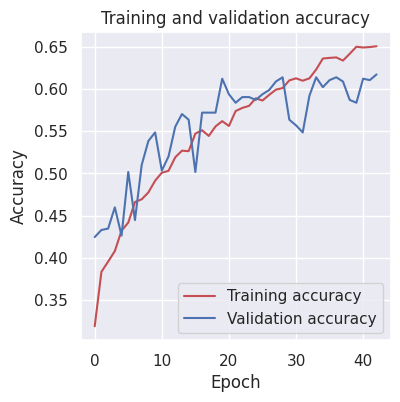

In [35]:
plt.figure(figsize=(4,4))
plt.plot(history['train_Accuracy'], 'r',label='Training accuracy')
plt.plot(history['val_Accuracy'], 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


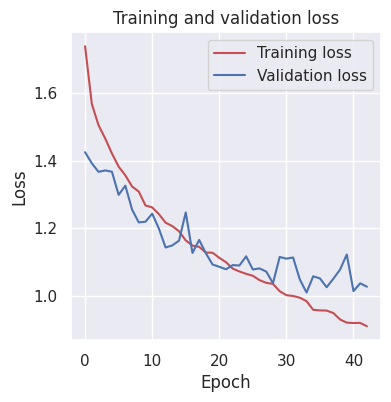

In [36]:
plt.figure(figsize=(4,4))
plt.plot(history['train_loss'], 'r', label='Training loss')
plt.plot(history['val_loss'], 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


In [37]:
def get_predicted(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for test_input, test_label in data_loader:
            test_label = test_label.to(device)
            test_input = test_input.to(device)

            output_logits, output_softmax = model(test_input.float())

            predictions = torch.argmax(output_softmax, dim=1)
            predicted_labels.extend(predictions.cpu().numpy())
            true_labels.extend(test_label.cpu().numpy())

            loss = loss_fn(output_logits, test_label)
            losses.append(loss.item())

    mean_loss = np.mean(losses)

    return mean_loss, predicted_labels, true_labels

In [38]:
mean_loss, predicted_labels, true_labels=get_predicted(model,test_dataloader,loss_fn,DEVICE)

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report,confusion_matrix

import matplotlib.pyplot as plt
def measurements_of_accuracy(Y_test,Y_pred,classifier,labels):
    # Calculate the confusion matrix
#     conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
#     matrix_precentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
#     for i in range(conf_matrix.shape[0]):
#         for j in range(conf_matrix.shape[1]):
#             ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
 
#     plt.xlabel('Predictions', fontsize=18)
#     plt.ylabel('Actuals', fontsize=18)
#     plt.title("Confusion Matrix for "+classifier+"Classifier", fontsize=18)
#     plt.grid(False)
#     plt.xticks(range(len(labels)), labels, rotation=90)  # Set x-axis labels
#     plt.yticks(range(len(labels)), labels)  # Set y-axis labels
#     plt.show()
    
#     #Accuracy
#     print('Accuracy : %.4f' % accuracy_score(Y_test, Y_pred))

#     #precision score
#     print('Precision : %.4f' % precision_score(Y_test, Y_pred,average='macro'))
    
#     #Recall Score
#     print('Recall : %.4f' % recall_score(Y_test, Y_pred,average='macro'))
    
#     #F1 score
#     print('F1 Score : %.4f' % f1_score(Y_test, Y_pred,average='macro'))
    
#         # Find the most confusing classes
#     misclassification_rates = 1 - np.diag(matrix_precentage)
#     most_confusing_classes = [labels[i] for i in np.argsort(misclassification_rates)[::-1]]
#     print("Most Confusing Classes:")
#     for i, label in enumerate(most_confusing_classes):
#         rate_percentage = misclassification_rates[i] * 100
#         print(f"{i + 1}. {label}: {rate_percentage:.2f}% (Misclassification rate)")
    cm = confusion_matrix(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred, target_names=labels)
    
    print('Classification Report:')
    print(report)
    
    sns.set()
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', annot_kws={"fontsize": 18}, xticklabels=labels, yticklabels=labels)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted labels', size=14)
    plt.ylabel('True labels', size=14)
    plt.show()


In [40]:
label_mapping

{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5}

Classification Report:
              precision    recall  f1-score   support

       Anger       0.83      0.61      0.71       254
     Disgust       0.57      0.46      0.51       254
        Fear       0.59      0.55      0.57       254
       Happy       0.59      0.62      0.60       255
     Neutral       0.55      0.88      0.68       218
         Sad       0.67      0.63      0.65       254

    accuracy                           0.62      1489
   macro avg       0.63      0.63      0.62      1489
weighted avg       0.63      0.62      0.62      1489



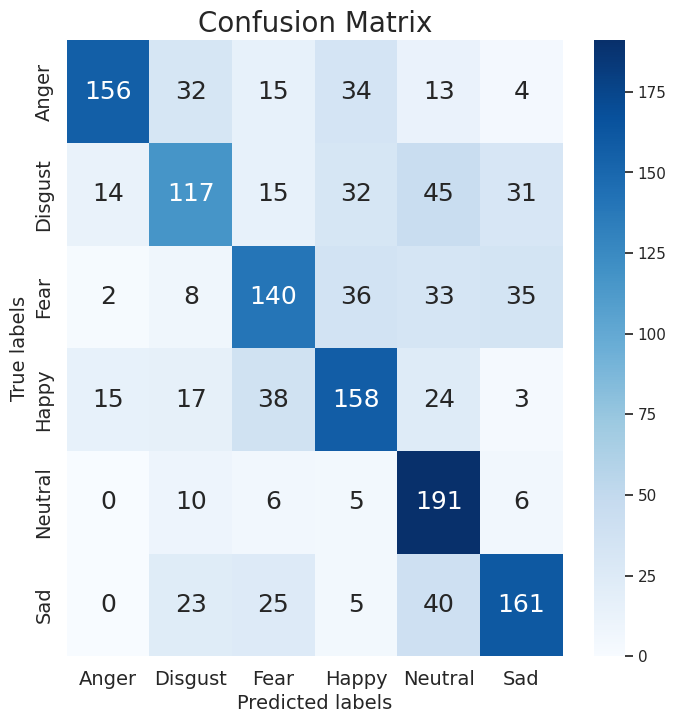

In [41]:
measurements_of_accuracy(true_labels,predicted_labels,"Confusion matrix",list(label_mapping.keys()))

# MODEL 2 Training

In [42]:
import torch.optim as optim
EPOCHS=500
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn =nn.CrossEntropyLoss().to(DEVICE)

LEARNING_RATE=1e-4
model = ParaNetTransformer(6).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [43]:
from collections import defaultdict
import math
history = defaultdict(list)
loss=math.inf
epochs_without_improvement = 0
patience = 30  # Number of epochs to wait for improvement

In [44]:
for epoch in range(EPOCHS):


    train_loss,train_acc = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)
    
    val_loss,val_acc = eval_model(model,val_dataloader,loss_fn, DEVICE)
    
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print(f'Train loss {train_loss}')
    print(f'Train Accuracy {train_acc}')

    print(f'Val   loss {val_loss}')
    print(f'Val   Acc {val_acc}')

    print()
        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement == patience:
        print("Early stopping triggered. No improvement in", patience, "epochs.")
        break



    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    
    history['train_Accuracy'].append(train_acc)
    history['val_Accuracy'].append(val_acc)

    #save this incase of failure
    torch.save(model.state_dict(), 'current_model_state.bin')
    
    
#save last state to train later
torch.save(model.state_dict(), 'last_model_state.bin')


100%|██████████| 670/670 [00:14<00:00, 47.37it/s]


Epoch 1, Learning Rate: 0.0001
Epoch 1/500
----------
Train loss 1.7550209174405282
Train Accuracy 0.321448571961919
Val   loss 1.4801998535792034
Val   Acc 0.3775167785234899



100%|██████████| 670/670 [00:14<00:00, 47.62it/s]


Epoch 2, Learning Rate: 0.0001
Epoch 2/500
----------
Train loss 1.5751731345013007
Train Accuracy 0.36382303528094084
Val   loss 1.4024697144826253
Val   Acc 0.39429530201342283



100%|██████████| 670/670 [00:14<00:00, 47.54it/s]


Epoch 3, Learning Rate: 0.0001
Epoch 3/500
----------
Train loss 1.5095527202335757
Train Accuracy 0.3858502893410491
Val   loss 1.365228443145752
Val   Acc 0.4563758389261745



100%|██████████| 670/670 [00:14<00:00, 47.67it/s]


Epoch 4, Learning Rate: 0.0001
Epoch 4/500
----------
Train loss 1.442224024391886
Train Accuracy 0.40918424491319766
Val   loss 1.3454963954289754
Val   Acc 0.43288590604026844



100%|██████████| 670/670 [00:14<00:00, 47.79it/s]


Epoch 5, Learning Rate: 0.0001
Epoch 5/500
----------
Train loss 1.4125965604141577
Train Accuracy 0.4271047227926078
Val   loss 1.3139852555592855
Val   Acc 0.45805369127516776



100%|██████████| 670/670 [00:14<00:00, 47.57it/s]


Epoch 6, Learning Rate: 0.0001
Epoch 6/500
----------
Train loss 1.390161498713849
Train Accuracy 0.4420384543587829
Val   loss 1.3631546624501547
Val   Acc 0.40436241610738255



100%|██████████| 670/670 [00:14<00:00, 47.68it/s]


Epoch 7, Learning Rate: 0.0001
Epoch 7/500
----------
Train loss 1.3646831009814988
Train Accuracy 0.45659884263580364
Val   loss 1.2932211724917093
Val   Acc 0.47651006711409394



100%|██████████| 670/670 [00:14<00:00, 47.24it/s]


Epoch 8, Learning Rate: 0.0001
Epoch 8/500
----------
Train loss 1.3313324906932773
Train Accuracy 0.4720925891357103
Val   loss 1.301726892789205
Val   Acc 0.4865771812080537



100%|██████████| 670/670 [00:13<00:00, 48.01it/s]


Epoch 9, Learning Rate: 0.0001
Epoch 9/500
----------
Train loss 1.3163869743471714
Train Accuracy 0.47657270860556283
Val   loss 1.2636131660143535
Val   Acc 0.5100671140939598



100%|██████████| 670/670 [00:14<00:00, 46.87it/s]


Epoch 10, Learning Rate: 0.0001
Epoch 10/500
----------
Train loss 1.291413187535841
Train Accuracy 0.49038641030427477
Val   loss 1.3097557568550109
Val   Acc 0.46476510067114096



100%|██████████| 670/670 [00:13<00:00, 48.01it/s]


Epoch 11, Learning Rate: 0.0001
Epoch 11/500
----------
Train loss 1.268717320685956
Train Accuracy 0.48982639537054323
Val   loss 1.2706699005762736
Val   Acc 0.45805369127516776



100%|██████████| 670/670 [00:14<00:00, 47.46it/s]


Epoch 12, Learning Rate: 0.0001
Epoch 12/500
----------
Train loss 1.244589915248885
Train Accuracy 0.508493559828262
Val   loss 1.218056498368581
Val   Acc 0.5285234899328859



100%|██████████| 670/670 [00:14<00:00, 47.62it/s]


Epoch 13, Learning Rate: 0.0001
Epoch 13/500
----------
Train loss 1.2357166916576785
Train Accuracy 0.504386783647564
Val   loss 1.182659448782603
Val   Acc 0.5335570469798657



100%|██████████| 670/670 [00:14<00:00, 47.38it/s]


Epoch 14, Learning Rate: 0.0001
Epoch 14/500
----------
Train loss 1.2089255991266734
Train Accuracy 0.5284674257980213
Val   loss 1.1696009119351705
Val   Acc 0.5436241610738255



100%|██████████| 670/670 [00:14<00:00, 47.59it/s]


Epoch 15, Learning Rate: 0.0001
Epoch 15/500
----------
Train loss 1.2102428360216653
Train Accuracy 0.5219339182378196
Val   loss 1.1770538012186686
Val   Acc 0.5369127516778524



100%|██████████| 670/670 [00:14<00:00, 47.20it/s]


Epoch 16, Learning Rate: 0.0001
Epoch 16/500
----------
Train loss 1.1884127339765207
Train Accuracy 0.5318275154004107
Val   loss 1.119428636233012
Val   Acc 0.5922818791946308



100%|██████████| 670/670 [00:14<00:00, 47.83it/s]


Epoch 17, Learning Rate: 0.0001
Epoch 17/500
----------
Train loss 1.170524728698517
Train Accuracy 0.5420944558521561
Val   loss 1.1414850417772928
Val   Acc 0.5721476510067114



100%|██████████| 670/670 [00:14<00:00, 47.24it/s]


Epoch 18, Learning Rate: 0.0001
Epoch 18/500
----------
Train loss 1.1666960765176744
Train Accuracy 0.5374276647377263
Val   loss 1.2124826216697693
Val   Acc 0.4899328859060403



100%|██████████| 670/670 [00:14<00:00, 47.61it/s]


Epoch 19, Learning Rate: 0.0001
Epoch 19/500
----------
Train loss 1.1439468034167788
Train Accuracy 0.5577748739966399
Val   loss 1.1831353211402893
Val   Acc 0.5436241610738255



100%|██████████| 670/670 [00:13<00:00, 47.95it/s]


Epoch 20, Learning Rate: 0.0001
Epoch 20/500
----------
Train loss 1.123256713952591
Train Accuracy 0.5596415904424118
Val   loss 1.1983331163724265
Val   Acc 0.5100671140939598



100%|██████████| 670/670 [00:14<00:00, 47.50it/s]


Epoch 21, Learning Rate: 0.0001
Epoch 21/500
----------
Train loss 1.119731899829053
Train Accuracy 0.5600149337315662
Val   loss 1.1379790635903677
Val   Acc 0.5570469798657718



100%|██████████| 670/670 [00:14<00:00, 47.83it/s]


Epoch 22, Learning Rate: 0.0001
Epoch 22/500
----------
Train loss 1.1037828549075483
Train Accuracy 0.5674817995146537
Val   loss 1.0824696310361226
Val   Acc 0.587248322147651



100%|██████████| 670/670 [00:14<00:00, 47.50it/s]


Epoch 23, Learning Rate: 0.0001
Epoch 23/500
----------
Train loss 1.0959519512617766
Train Accuracy 0.574761993653164
Val   loss 1.1434277776877086
Val   Acc 0.5486577181208053



100%|██████████| 670/670 [00:13<00:00, 47.94it/s]


Epoch 24, Learning Rate: 0.0001
Epoch 24/500
----------
Train loss 1.0832178988563481
Train Accuracy 0.5742019787194326
Val   loss 1.0970971854527791
Val   Acc 0.5704697986577181



100%|██████████| 670/670 [00:14<00:00, 47.39it/s]


Epoch 25, Learning Rate: 0.0001
Epoch 25/500
----------
Train loss 1.074801641168879
Train Accuracy 0.5872689938398358
Val   loss 1.042501236597697
Val   Acc 0.6157718120805369



100%|██████████| 670/670 [00:14<00:00, 47.71it/s]


Epoch 26, Learning Rate: 0.0001
Epoch 26/500
----------
Train loss 1.0725506741164335
Train Accuracy 0.5783087549001307
Val   loss 1.098413377602895
Val   Acc 0.5956375838926175



100%|██████████| 670/670 [00:14<00:00, 47.55it/s]


Epoch 27, Learning Rate: 0.0001
Epoch 27/500
----------
Train loss 1.0507748337823952
Train Accuracy 0.5943625163337689
Val   loss 1.1048649621009827
Val   Acc 0.575503355704698



100%|██████████| 670/670 [00:13<00:00, 47.91it/s]


Epoch 28, Learning Rate: 0.0001
Epoch 28/500
----------
Train loss 1.0434757676142365
Train Accuracy 0.587455665484413
Val   loss 1.069548916419347
Val   Acc 0.5838926174496645



100%|██████████| 670/670 [00:13<00:00, 47.87it/s]


Epoch 29, Learning Rate: 0.0001
Epoch 29/500
----------
Train loss 1.0355798704855477
Train Accuracy 0.5945491879783461
Val   loss 1.0078011858463287
Val   Acc 0.6325503355704698



100%|██████████| 670/670 [00:14<00:00, 47.51it/s]


Epoch 30, Learning Rate: 0.0001
Epoch 30/500
----------
Train loss 1.0324227825029573
Train Accuracy 0.5887623669964532
Val   loss 1.0489447124799092
Val   Acc 0.6174496644295302



100%|██████████| 670/670 [00:14<00:00, 46.91it/s]


Epoch 31, Learning Rate: 0.0001
Epoch 31/500
----------
Train loss 1.0205370960840539
Train Accuracy 0.6081762180324809
Val   loss 1.0343769379456837
Val   Acc 0.6140939597315436



100%|██████████| 670/670 [00:14<00:00, 47.49it/s]


Epoch 32, Learning Rate: 0.0001
Epoch 32/500
----------
Train loss 1.0229442215232707
Train Accuracy 0.5915624416651111
Val   loss 1.0170078281561534
Val   Acc 0.6191275167785235



100%|██████████| 670/670 [00:13<00:00, 48.19it/s]


Epoch 33, Learning Rate: 0.0001
Epoch 33/500
----------
Train loss 1.0003896484179284
Train Accuracy 0.609296247899944
Val   loss 1.0104146603743236
Val   Acc 0.6090604026845637



100%|██████████| 670/670 [00:14<00:00, 47.36it/s]


Epoch 34, Learning Rate: 0.0001
Epoch 34/500
----------
Train loss 1.0037249592257969
Train Accuracy 0.6089229046107896
Val   loss 1.0457288094361623
Val   Acc 0.6258389261744967



100%|██████████| 670/670 [00:14<00:00, 47.46it/s]


Epoch 35, Learning Rate: 0.0001
Epoch 35/500
----------
Train loss 0.9779561166443042
Train Accuracy 0.6219899197311929
Val   loss 1.003352295557658
Val   Acc 0.6073825503355704



100%|██████████| 670/670 [00:14<00:00, 47.17it/s]


Epoch 36, Learning Rate: 0.0001
Epoch 36/500
----------
Train loss 0.9867172965585296
Train Accuracy 0.625163337689005
Val   loss 1.0795385845502217
Val   Acc 0.5889261744966443



100%|██████████| 670/670 [00:13<00:00, 47.94it/s]


Epoch 37, Learning Rate: 0.0001
Epoch 37/500
----------
Train loss 0.9645842742341668
Train Accuracy 0.6328168751166697
Val   loss 1.0087211147944133
Val   Acc 0.6191275167785235



100%|██████████| 670/670 [00:14<00:00, 47.57it/s]


Epoch 38, Learning Rate: 0.0001
Epoch 38/500
----------
Train loss 0.9657012952352637
Train Accuracy 0.6283367556468172
Val   loss 1.0553096961975097
Val   Acc 0.5922818791946308



100%|██████████| 670/670 [00:14<00:00, 46.67it/s]


Epoch 39, Learning Rate: 0.0001
Epoch 39/500
----------
Train loss 0.9557110701034318
Train Accuracy 0.6341235766287101
Val   loss 1.0064007679621378
Val   Acc 0.6174496644295302



100%|██████████| 670/670 [00:14<00:00, 45.78it/s]


Epoch 40, Learning Rate: 0.0001
Epoch 40/500
----------
Train loss 0.9458252918364397
Train Accuracy 0.6404704125443346
Val   loss 1.0893128923575084
Val   Acc 0.6023489932885906



100%|██████████| 670/670 [00:14<00:00, 46.07it/s]


Epoch 41, Learning Rate: 0.0001
Epoch 41/500
----------
Train loss 0.9455447492759619
Train Accuracy 0.6346835915624417
Val   loss 1.0010289315382639
Val   Acc 0.6375838926174496



100%|██████████| 670/670 [00:14<00:00, 45.56it/s]


Epoch 42, Learning Rate: 0.0001
Epoch 42/500
----------
Train loss 0.9390455460815287
Train Accuracy 0.6412170991226432
Val   loss 1.0502722851435344
Val   Acc 0.6174496644295302



100%|██████████| 670/670 [00:14<00:00, 45.90it/s]


Epoch 43, Learning Rate: 0.0001
Epoch 43/500
----------
Train loss 0.9346694396058125
Train Accuracy 0.6434571588575695
Val   loss 1.0529015453656514
Val   Acc 0.5973154362416108



100%|██████████| 670/670 [00:14<00:00, 45.26it/s]


Epoch 44, Learning Rate: 0.0001
Epoch 44/500
----------
Train loss 0.9233876163612551
Train Accuracy 0.6440171737913011
Val   loss 1.0150861183802287
Val   Acc 0.6208053691275168



100%|██████████| 670/670 [00:14<00:00, 45.89it/s]


Epoch 45, Learning Rate: 0.0001
Epoch 45/500
----------
Train loss 0.9134505937126145
Train Accuracy 0.6451372036587643
Val   loss 0.986022101243337
Val   Acc 0.6459731543624161



100%|██████████| 670/670 [00:14<00:00, 45.86it/s]


Epoch 46, Learning Rate: 0.0001
Epoch 46/500
----------
Train loss 0.9008552666030712
Train Accuracy 0.6524173977972746
Val   loss 1.0364097793896994
Val   Acc 0.6057046979865772



100%|██████████| 670/670 [00:14<00:00, 45.99it/s]


Epoch 47, Learning Rate: 0.0001
Epoch 47/500
----------
Train loss 0.8888915866168577
Train Accuracy 0.6591375770020534
Val   loss 1.0444494990507762
Val   Acc 0.610738255033557



100%|██████████| 670/670 [00:14<00:00, 45.39it/s]


Epoch 48, Learning Rate: 0.0001
Epoch 48/500
----------
Train loss 0.8961026722815499
Train Accuracy 0.6578308754900131
Val   loss 1.0286647737026215
Val   Acc 0.6291946308724832



100%|██████████| 670/670 [00:14<00:00, 45.91it/s]


Epoch 49, Learning Rate: 0.0001
Epoch 49/500
----------
Train loss 0.8724814441889079
Train Accuracy 0.6632443531827515
Val   loss 0.9804107856750488
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:14<00:00, 45.51it/s]


Epoch 50, Learning Rate: 0.0001
Epoch 50/500
----------
Train loss 0.8781276093712493
Train Accuracy 0.6651110696285234
Val   loss 0.947876614332199
Val   Acc 0.6543624161073825



100%|██████████| 670/670 [00:14<00:00, 45.72it/s]


Epoch 51, Learning Rate: 0.0001
Epoch 51/500
----------
Train loss 0.8638683102024135
Train Accuracy 0.6654844129176778
Val   loss 1.031200829744339
Val   Acc 0.6191275167785235



100%|██████████| 670/670 [00:14<00:00, 46.18it/s]


Epoch 52, Learning Rate: 0.0001
Epoch 52/500
----------
Train loss 0.8648705998018607
Train Accuracy 0.665671084562255
Val   loss 0.9766572229067485
Val   Acc 0.6442953020134228



100%|██████████| 670/670 [00:14<00:00, 45.55it/s]


Epoch 53, Learning Rate: 0.0001
Epoch 53/500
----------
Train loss 0.8457443611390555
Train Accuracy 0.6764980399477319
Val   loss 0.9606127878030141
Val   Acc 0.6526845637583892



100%|██████████| 670/670 [00:14<00:00, 45.35it/s]


Epoch 54, Learning Rate: 0.0001
Epoch 54/500
----------
Train loss 0.8514438820419027
Train Accuracy 0.6751913384356916
Val   loss 0.9633640011151632
Val   Acc 0.6459731543624161



100%|██████████| 670/670 [00:14<00:00, 47.26it/s]


Epoch 55, Learning Rate: 0.0001
Epoch 55/500
----------
Train loss 0.8539831817594927
Train Accuracy 0.6690311741646444
Val   loss 1.018701103925705
Val   Acc 0.6073825503355704



100%|██████████| 670/670 [00:13<00:00, 48.15it/s]


Epoch 56, Learning Rate: 0.0001
Epoch 56/500
----------
Train loss 0.8141387998835364
Train Accuracy 0.6830315475079335
Val   loss 1.029196017185847
Val   Acc 0.6124161073825504



100%|██████████| 670/670 [00:14<00:00, 47.34it/s]


Epoch 57, Learning Rate: 0.0001
Epoch 57/500
----------
Train loss 0.8285657368489165
Train Accuracy 0.6832182191525107
Val   loss 0.9704483266671499
Val   Acc 0.6258389261744967



100%|██████████| 670/670 [00:13<00:00, 48.02it/s]


Epoch 58, Learning Rate: 0.0001
Epoch 58/500
----------
Train loss 0.813065159432034
Train Accuracy 0.6903117416464439
Val   loss 1.0751144534349442
Val   Acc 0.6073825503355704



100%|██████████| 670/670 [00:14<00:00, 47.49it/s]


Epoch 59, Learning Rate: 0.0001
Epoch 59/500
----------
Train loss 0.8182257178114422
Train Accuracy 0.6947918611162964
Val   loss 1.004175262451172
Val   Acc 0.6476510067114094



100%|██████████| 670/670 [00:13<00:00, 48.43it/s]


Epoch 60, Learning Rate: 0.0001
Epoch 60/500
----------
Train loss 0.8190686145380361
Train Accuracy 0.6876983386223633
Val   loss 1.003792692621549
Val   Acc 0.6442953020134228



100%|██████████| 670/670 [00:14<00:00, 47.01it/s]


Epoch 61, Learning Rate: 0.0001
Epoch 61/500
----------
Train loss 0.8192973173598745
Train Accuracy 0.6931118163151018
Val   loss 1.0236734608809153
Val   Acc 0.6208053691275168



100%|██████████| 670/670 [00:14<00:00, 47.60it/s]


Epoch 62, Learning Rate: 0.0001
Epoch 62/500
----------
Train loss 0.7975262766231351
Train Accuracy 0.696285234272914
Val   loss 1.0432047132651012
Val   Acc 0.62751677852349



100%|██████████| 670/670 [00:14<00:00, 47.71it/s]


Epoch 63, Learning Rate: 0.0001
Epoch 63/500
----------
Train loss 0.7972423640649711
Train Accuracy 0.7011386970319209
Val   loss 0.9471404337882996
Val   Acc 0.6610738255033557



100%|██████████| 670/670 [00:13<00:00, 48.26it/s]


Epoch 64, Learning Rate: 0.0001
Epoch 64/500
----------
Train loss 0.7836655399692593
Train Accuracy 0.695351876050028
Val   loss 0.988528360525767
Val   Acc 0.6291946308724832



100%|██████████| 670/670 [00:14<00:00, 47.16it/s]


Epoch 65, Learning Rate: 0.0001
Epoch 65/500
----------
Train loss 0.7633195174162957
Train Accuracy 0.7063655030800822
Val   loss 0.9992314759890238
Val   Acc 0.6375838926174496



100%|██████████| 670/670 [00:14<00:00, 47.81it/s]


Epoch 66, Learning Rate: 0.0001
Epoch 66/500
----------
Train loss 0.7680843694441354
Train Accuracy 0.7063655030800822
Val   loss 0.9696248110135396
Val   Acc 0.6560402684563759



100%|██████████| 670/670 [00:14<00:00, 47.74it/s]


Epoch 67, Learning Rate: 0.0001
Epoch 67/500
----------
Train loss 0.7590931730483895
Train Accuracy 0.7145790554414785
Val   loss 0.9980652391910553
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:13<00:00, 47.98it/s]


Epoch 68, Learning Rate: 0.0001
Epoch 68/500
----------
Train loss 0.7545608246281965
Train Accuracy 0.7177524733992906
Val   loss 0.9744042793909709
Val   Acc 0.6543624161073825



100%|██████████| 670/670 [00:13<00:00, 48.13it/s]


Epoch 69, Learning Rate: 0.0001
Epoch 69/500
----------
Train loss 0.7399375688673845
Train Accuracy 0.7127123389957065
Val   loss 0.9791206045945485
Val   Acc 0.639261744966443



100%|██████████| 670/670 [00:14<00:00, 47.39it/s]


Epoch 70, Learning Rate: 0.0001
Epoch 70/500
----------
Train loss 0.7594317103722202
Train Accuracy 0.7117789807728206
Val   loss 0.9368886152903239
Val   Acc 0.6677852348993288



100%|██████████| 670/670 [00:13<00:00, 48.41it/s]


Epoch 71, Learning Rate: 0.0001
Epoch 71/500
----------
Train loss 0.7483256614030297
Train Accuracy 0.720179204778794
Val   loss 1.017826197942098
Val   Acc 0.6342281879194631



100%|██████████| 670/670 [00:14<00:00, 47.29it/s]


Epoch 72, Learning Rate: 0.0001
Epoch 72/500
----------
Train loss 0.7301645015491478
Train Accuracy 0.7240993093149151
Val   loss 0.9555031141638756
Val   Acc 0.6510067114093959



100%|██████████| 670/670 [00:13<00:00, 48.15it/s]


Epoch 73, Learning Rate: 0.0001
Epoch 73/500
----------
Train loss 0.7225456002043255
Train Accuracy 0.7276460705618817
Val   loss 0.966530648469925
Val   Acc 0.6459731543624161



100%|██████████| 670/670 [00:14<00:00, 46.82it/s]


Epoch 74, Learning Rate: 0.0001
Epoch 74/500
----------
Train loss 0.7311652688837763
Train Accuracy 0.7209258913571028
Val   loss 0.9701855111122132
Val   Acc 0.6308724832214765



100%|██████████| 670/670 [00:14<00:00, 47.15it/s]


Epoch 75, Learning Rate: 0.0001
Epoch 75/500
----------
Train loss 0.7046105883793155
Train Accuracy 0.7308194885196938
Val   loss 0.9817229137818019
Val   Acc 0.6409395973154363



100%|██████████| 670/670 [00:14<00:00, 46.66it/s]


Epoch 76, Learning Rate: 0.0001
Epoch 76/500
----------
Train loss 0.6949758874947456
Train Accuracy 0.7375396677244727
Val   loss 1.0041972599426905
Val   Acc 0.6409395973154363



100%|██████████| 670/670 [00:14<00:00, 47.62it/s]


Epoch 77, Learning Rate: 0.0001
Epoch 77/500
----------
Train loss 0.6898890862269188
Train Accuracy 0.737913011013627
Val   loss 0.9920269672075908
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:14<00:00, 47.51it/s]


Epoch 78, Learning Rate: 0.0001
Epoch 78/500
----------
Train loss 0.7069739106653342
Train Accuracy 0.731939518387157
Val   loss 1.107277400890986
Val   Acc 0.6090604026845637



100%|██████████| 670/670 [00:14<00:00, 47.52it/s]


Epoch 79, Learning Rate: 0.0001
Epoch 79/500
----------
Train loss 0.6908042962204165
Train Accuracy 0.7371663244353183
Val   loss 0.98291387150685
Val   Acc 0.6426174496644296



100%|██████████| 670/670 [00:14<00:00, 47.09it/s]


Epoch 80, Learning Rate: 0.0001
Epoch 80/500
----------
Train loss 0.6764097257225371
Train Accuracy 0.7423931304834795
Val   loss 0.9404018227259318
Val   Acc 0.6661073825503355



100%|██████████| 670/670 [00:13<00:00, 47.96it/s]


Epoch 81, Learning Rate: 0.0001
Epoch 81/500
----------
Train loss 0.6846477205406374
Train Accuracy 0.7356729512787008
Val   loss 1.0132744204998017
Val   Acc 0.62751677852349



100%|██████████| 670/670 [00:13<00:00, 48.36it/s]


Epoch 82, Learning Rate: 0.0001
Epoch 82/500
----------
Train loss 0.6616690985302427
Train Accuracy 0.7571401904050775
Val   loss 0.9713507227102915
Val   Acc 0.6476510067114094



100%|██████████| 670/670 [00:13<00:00, 48.06it/s]


Epoch 83, Learning Rate: 0.0001
Epoch 83/500
----------
Train loss 0.6706537585538714
Train Accuracy 0.7397797274593989
Val   loss 0.9544789032141368
Val   Acc 0.6476510067114094



100%|██████████| 670/670 [00:13<00:00, 48.38it/s]


Epoch 84, Learning Rate: 0.0001
Epoch 84/500
----------
Train loss 0.6592530864944209
Train Accuracy 0.7464999066641778
Val   loss 1.0053486768404643
Val   Acc 0.6258389261744967



100%|██████████| 670/670 [00:13<00:00, 47.99it/s]


Epoch 85, Learning Rate: 0.0001
Epoch 85/500
----------
Train loss 0.6497526385446093
Train Accuracy 0.7565801754713459
Val   loss 0.9645104320844015
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:13<00:00, 47.96it/s]


Epoch 86, Learning Rate: 0.0001
Epoch 86/500
----------
Train loss 0.6468961288679892
Train Accuracy 0.7580735486279634
Val   loss 1.0512549289067585
Val   Acc 0.6258389261744967



100%|██████████| 670/670 [00:14<00:00, 47.57it/s]


Epoch 87, Learning Rate: 0.0001
Epoch 87/500
----------
Train loss 0.6375055323452202
Train Accuracy 0.7608736232966212
Val   loss 0.9632886759440105
Val   Acc 0.6526845637583892



100%|██████████| 670/670 [00:14<00:00, 46.88it/s]


Epoch 88, Learning Rate: 0.0001
Epoch 88/500
----------
Train loss 0.6343206260408928
Train Accuracy 0.7593802501400038
Val   loss 1.0459513528148334
Val   Acc 0.6090604026845637



100%|██████████| 670/670 [00:14<00:00, 45.35it/s]


Epoch 89, Learning Rate: 0.0001
Epoch 89/500
----------
Train loss 0.6285988034597084
Train Accuracy 0.764607056188165
Val   loss 0.9456860510508219
Val   Acc 0.6442953020134228



100%|██████████| 670/670 [00:14<00:00, 45.92it/s]


Epoch 90, Learning Rate: 0.0001
Epoch 90/500
----------
Train loss 0.6288310672921031
Train Accuracy 0.7638603696098563
Val   loss 0.993774463335673
Val   Acc 0.6476510067114094



100%|██████████| 670/670 [00:14<00:00, 46.24it/s]


Epoch 91, Learning Rate: 0.0001
Epoch 91/500
----------
Train loss 0.6210821509806078
Train Accuracy 0.7659137577002053
Val   loss 1.0285667904218039
Val   Acc 0.6124161073825504



100%|██████████| 670/670 [00:14<00:00, 46.23it/s]


Epoch 92, Learning Rate: 0.0001
Epoch 92/500
----------
Train loss 0.6035790184429333
Train Accuracy 0.7720739219712526
Val   loss 0.9961161462465922
Val   Acc 0.6342281879194631



100%|██████████| 670/670 [00:14<00:00, 45.72it/s]


Epoch 93, Learning Rate: 0.0001
Epoch 93/500
----------
Train loss 0.6195313048451694
Train Accuracy 0.768527160724286
Val   loss 0.9892043479283651
Val   Acc 0.6577181208053692



100%|██████████| 670/670 [00:14<00:00, 46.76it/s]


Epoch 94, Learning Rate: 0.0001
Epoch 94/500
----------
Train loss 0.6030107472814731
Train Accuracy 0.7746873249953332
Val   loss 1.0355927342176436
Val   Acc 0.6157718120805369



100%|██████████| 670/670 [00:13<00:00, 48.66it/s]


Epoch 95, Learning Rate: 0.0001
Epoch 95/500
----------
Train loss 0.5870996503798819
Train Accuracy 0.777487399663991
Val   loss 0.9964677911996841
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:13<00:00, 48.09it/s]


Epoch 96, Learning Rate: 0.0001
Epoch 96/500
----------
Train loss 0.5904787589142572
Train Accuracy 0.7888743699831996
Val   loss 1.0002702339490255
Val   Acc 0.6325503355704698



100%|██████████| 670/670 [00:14<00:00, 47.74it/s]


Epoch 97, Learning Rate: 0.0001
Epoch 97/500
----------
Train loss 0.5834827721007725
Train Accuracy 0.7797274593989173
Val   loss 0.9626957513888676
Val   Acc 0.6694630872483222



100%|██████████| 670/670 [00:13<00:00, 48.00it/s]


Epoch 98, Learning Rate: 0.0001
Epoch 98/500
----------
Train loss 0.5874083118096216
Train Accuracy 0.7799141310434945
Val   loss 0.9554324354728063
Val   Acc 0.6677852348993288



100%|██████████| 670/670 [00:14<00:00, 47.61it/s]


Epoch 99, Learning Rate: 0.0001
Epoch 99/500
----------
Train loss 0.5707097313630937
Train Accuracy 0.7860742953145418
Val   loss 1.0228941110769907
Val   Acc 0.6342281879194631



100%|██████████| 670/670 [00:14<00:00, 47.59it/s]


Epoch 100, Learning Rate: 0.0001
Epoch 100/500
----------
Train loss 0.5712691869308699
Train Accuracy 0.7855142803808102
Val   loss 1.073778978784879
Val   Acc 0.6157718120805369

Early stopping triggered. No improvement in 30 epochs.


In [45]:
model.load_state_dict(torch.load('/kaggle/working/current_model_state.bin'))

<All keys matched successfully>

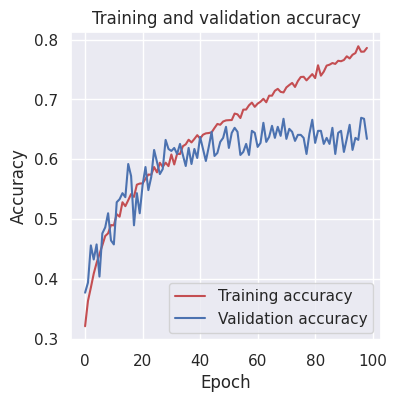

In [46]:
plt.figure(figsize=(4,4))
plt.plot(history['train_Accuracy'], 'r',label='Training accuracy')
plt.plot(history['val_Accuracy'], 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


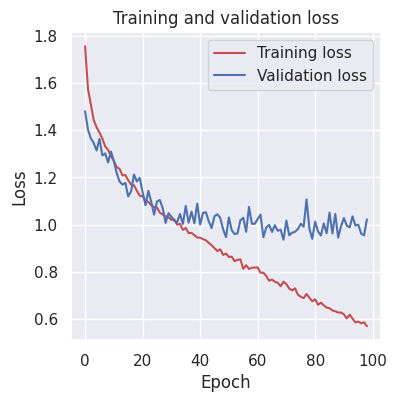

In [47]:
plt.figure(figsize=(4,4))
plt.plot(history['train_loss'], 'r', label='Training loss')
plt.plot(history['val_loss'], 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


In [48]:
mean_loss, predicted_labels, true_labels=get_predicted(model,test_dataloader,loss_fn,DEVICE)

Classification Report:
              precision    recall  f1-score   support

       Anger       0.77      0.75      0.76       254
     Disgust       0.76      0.41      0.53       254
        Fear       0.47      0.70      0.57       254
       Happy       0.66      0.63      0.65       255
     Neutral       0.63      0.86      0.72       218
         Sad       0.66      0.49      0.56       254

    accuracy                           0.63      1489
   macro avg       0.66      0.64      0.63      1489
weighted avg       0.66      0.63      0.63      1489



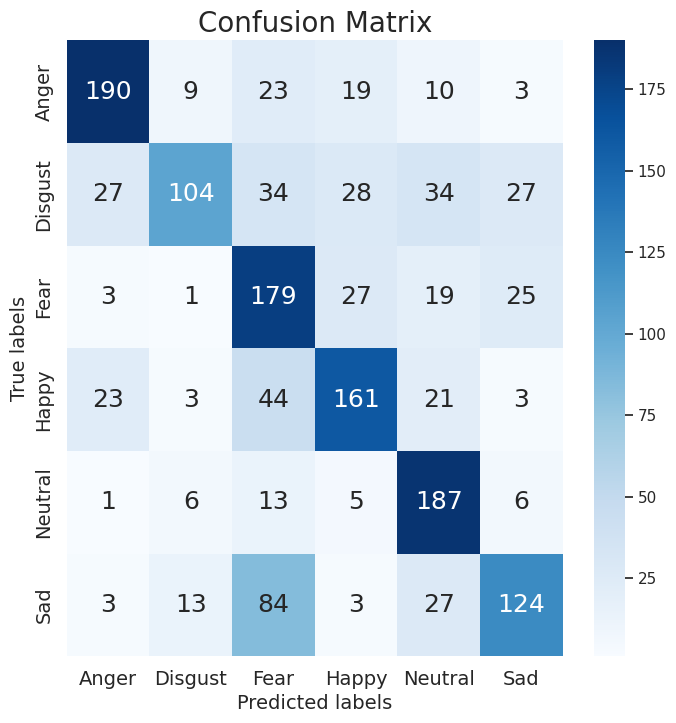

In [49]:
measurements_of_accuracy(true_labels,predicted_labels,"Confusion matrix",list(label_mapping.keys()))